# Определение возраста человека

## Описание данных

Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/).

Структура данных:
* *labels.csv* - файл с именами файлов изображения и реальным возрастом человека
  - *file_name* - каталог с фотографиями людей
  - *real_age*  - реальный возраст человека
* *final_files* - каталог с фотографиями людей

## Импорт библиотек

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil psutil humanize 1>/dev/null
!pip install -U seaborn 1>/dev/null

import psutil
import humanize
import GPUtil as GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import warnings
warnings.filterwarnings('ignore')

# загрузка/сохранение данных
import requests
from urllib.parse import urlencode

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def get_url(link):
    """
    Получение адреса для скачивания с Яндекс.Диск
    link - ссылка на Яндекс.Диск
    """
    print("Run", link)
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return url

In [5]:
# # раскомментировать, если нужно выкачать данные
# DATA_LINK = get_url('https://yadi.sk/d/fBaIaIhjZ7l1Sw?w=1')

In [6]:
# # раскомментировать, если нужно выкачать данные
# %%bash -s "$DATA_LINK"
# link="$1"
# out_file="data_faces_$(date +'%Y-%m-%d').zip"
# wget $link --output-document=$out_file
# unzip $out_file

In [7]:
# PATH = "./faces/"
PATH = "/content/drive/My Drive/datasets/faces"
RANDOM = 12345

## Функции

In [8]:
def print_img(df, age=None, count=8, path='/datasets/faces/final_files/'):
    # вывод изображений датасета
    cols = 4
    ost = 1 if count %cols else 0
    rows = count//cols + ost
    coord = [ (i, j) for i in range(rows) for j in range(cols)]
    df_age = df[df.real_age == age] if age else df.copy()    
    total = len(df_age)
    sample = df_age.file_name.sample(count)
    img_list = [ os.path.join(path,f) for f in sample ]
    fig = plt.figure(figsize=(cols*4,cols*rows-1))
    print(f'Show images for age {age}: {count}/{total}')
    
    for i, img in enumerate(img_list, 1):
        ax = fig.add_subplot(rows, cols, i)
        plt.imshow(mpimg.imread(img))
        plt.title(img.split('/')[-1])


def load_train(image_path, labels, test_size=0.3):
  train_datagen = ImageDataGenerator(
      validation_split=test_size,
      rescale=1./255,
      horizontal_flip=True,
      rotation_range=45
      )
  train_data = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=image_path,
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=RANDOM
      )
  return train_data


def load_test(image_path, labels, test_size=0.3):
  test_datagen = ImageDataGenerator(
      validation_split=test_size, 
      rescale=1./255
      )
  test_data = test_datagen.flow_from_dataframe(
      dataframe=labels, 
      directory=image_path, 
      x_col='file_name', 
      y_col='real_age',
      target_size=(224, 224), 
      batch_size=32, 
      class_mode='raw', 
      subset='validation', 
      seed=RANDOM
      )
  return test_data


def create_model(input_shape):
    # создание модели
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):
    # обучение модели
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    with tf.device('/GPU:0'):
      model.fit(train_data, 
        validation_data=test_data,
        batch_size=batch_size, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True, 
        )

    return model

## Исследовательский анализ данных

In [9]:
# PATH = "/datasets/faces/"

image_path  = os.path.join(PATH,'final_files')
labels_path = os.path.join(PATH, 'labels.csv')
labels = pd.read_csv(labels_path)

In [10]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


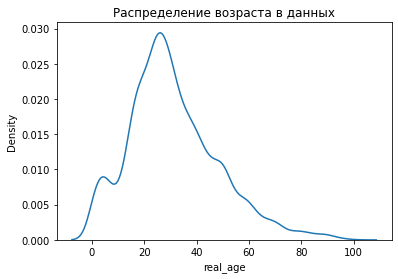

In [11]:
sns.distplot(labels.real_age, hist=False);
plt.title('Распределение возраста в данных');

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


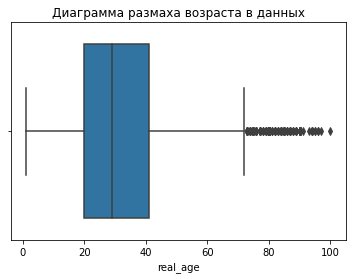

In [12]:
print(labels.real_age.describe())
sns.boxplot(labels.real_age);
plt.title('Диаграмма размаха возраста в данных');

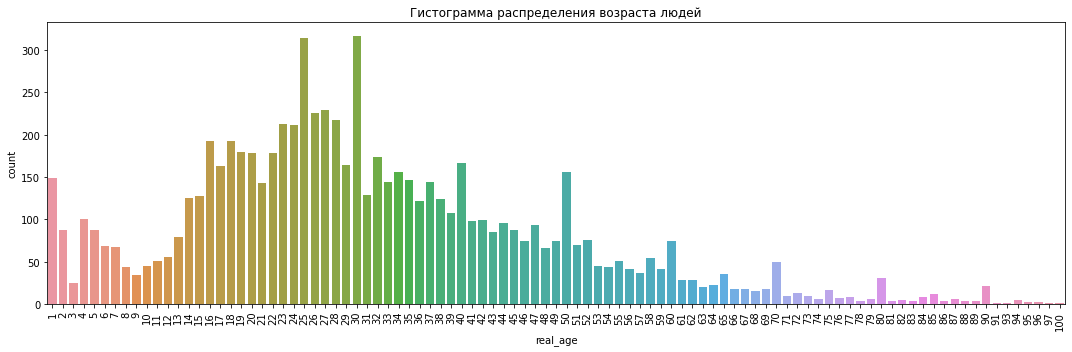

In [13]:
_, ax = plt.subplots(figsize=(15,5));
sns.countplot(labels.real_age, ax=ax);
plt.xticks(rotation=90);
plt.title('Гистограмма распределения возраста людей');
plt.tight_layout()

Из графиков:
* присутствует бимодальность;
* разное количество возрастов;
* мало пожилых людей;
* есть младенцы, столетние люди.

Show images for age None: 8/81


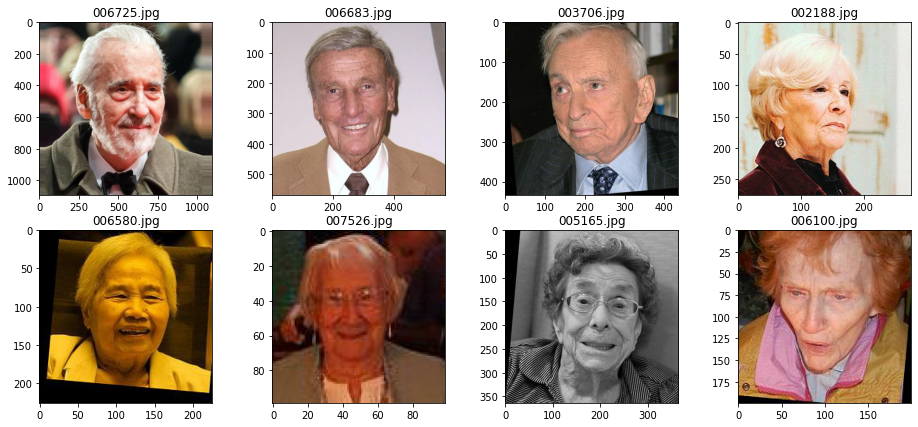

In [14]:
# посмотрим на людей старше 80 лет
people = labels[labels.real_age > 80]
print_img(people, count=8, path=image_path)

Show images for age 4: 8/101


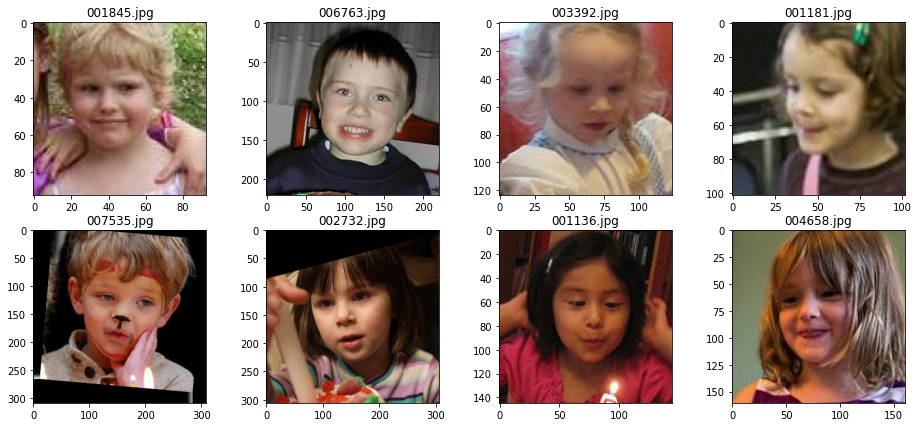

In [15]:
# посмотрим на фотографии детей
print_img(labels, count=8, age=4, path=image_path)

Show images for age 20: 8/178


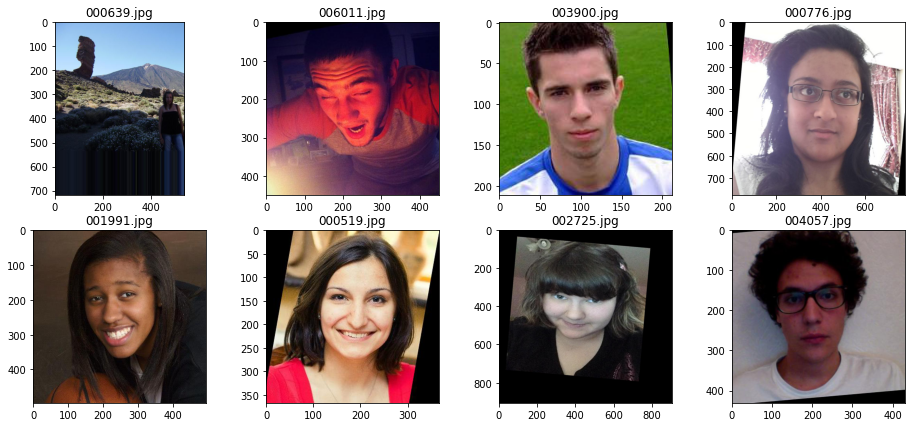

In [16]:
# 20 лет
print_img(labels, count=8, age=20, path=image_path)

Show images for age 45: 8/88


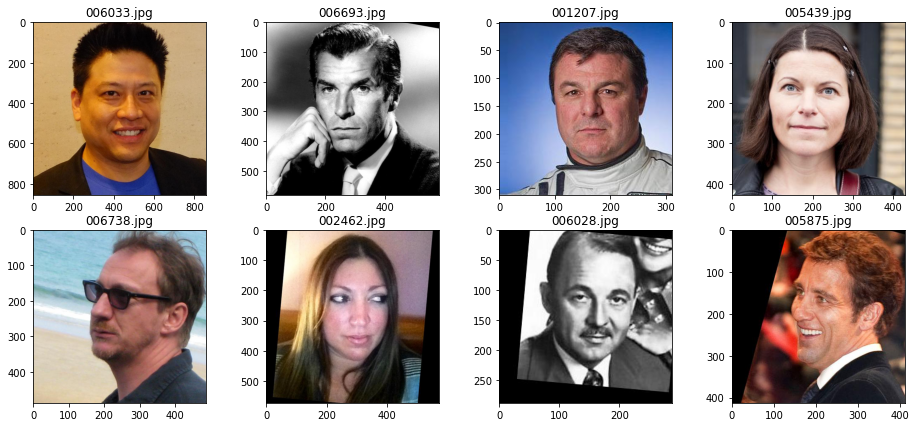

In [17]:
# 45 лет
print_img(labels, count=8, age=45, path=image_path)

В данных представлено большое количество фотографий людей различного возраста. Изображения имеют различное качество и особенности:
- разная национальность
- обрезанные фотографии (отсутствует часть лица на изображении)
- повернутые и смещенные фотографии
- цветные и черно-белые изображения
- люди в головных уборах и/или очках

Встечаются также, фото, не отражающие людей вообще или с неверным возрастом.


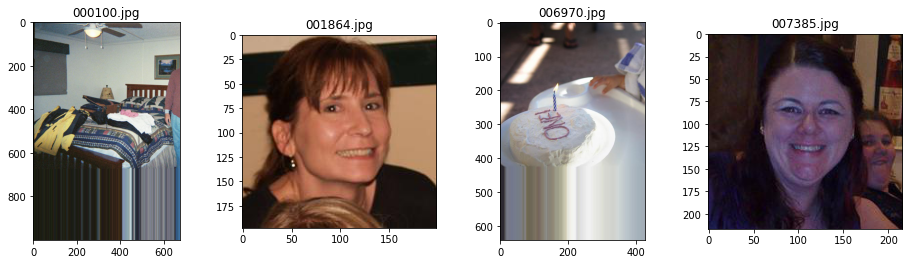

In [18]:
fig = plt.figure(figsize=(16, 4))
img_list = ['000100.jpg', '001864.jpg', '006970.jpg', '007385.jpg']

for i, img in enumerate(img_list, 1):
  fig.add_subplot(1, 4, i)
  plt.imshow(mpimg.imread(os.path.join(image_path, img)));
  plt.title(img)

## Обучение модели

In [19]:
# загрузка данных

train_data = load_train(image_path, labels, test_size=0.25)
test_data = load_test(image_path, labels, test_size=0.25)

# создание модели
model = create_model(train_data.image_shape)
print(model.summary())

Found 5694 validated image filenames.
Found 1897 validated image filenames.
94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None


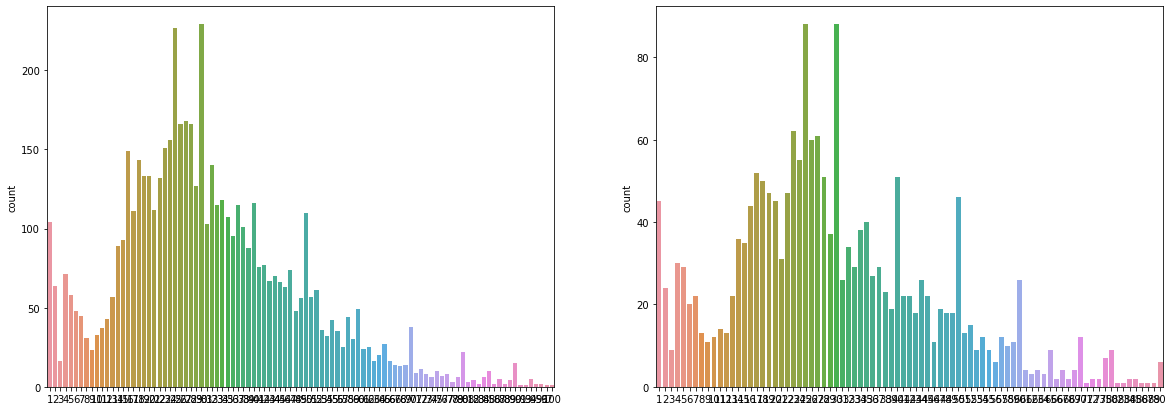

In [20]:
# Посмотрим на распределение возрастов в обучающей и тестовой выборке
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7));
sns.countplot(train_data.labels, ax=ax1);
sns.countplot(test_data.labels, ax=ax2);

In [21]:
# используемое устройство
tf.test.gpu_device_name()

'/device:GPU:0'

In [22]:
%%time

# обучение модели
trained_model = train_model(model, train_data, test_data, batch_size=32, epochs=20)

Epoch 1/20
178/178 - 3256s - loss: 271.8603 - mae: 11.9446 - val_loss: 822.8157 - val_mae: 23.7931
Epoch 2/20
178/178 - 113s - loss: 110.7910 - mae: 7.9984 - val_loss: 731.6909 - val_mae: 22.0453
Epoch 3/20
178/178 - 113s - loss: 90.5095 - mae: 7.1683 - val_loss: 285.9189 - val_mae: 12.5826
Epoch 4/20
178/178 - 114s - loss: 74.3955 - mae: 6.5360 - val_loss: 133.4252 - val_mae: 8.8848
Epoch 5/20
178/178 - 113s - loss: 68.1386 - mae: 6.2750 - val_loss: 94.0320 - val_mae: 7.2975
Epoch 6/20
178/178 - 114s - loss: 58.0542 - mae: 5.8124 - val_loss: 76.5013 - val_mae: 6.4257
Epoch 7/20
178/178 - 113s - loss: 55.0362 - mae: 5.6459 - val_loss: 99.2038 - val_mae: 7.2920
Epoch 8/20
178/178 - 113s - loss: 51.9167 - mae: 5.4946 - val_loss: 89.8558 - val_mae: 6.7941
Epoch 9/20
178/178 - 113s - loss: 46.2530 - mae: 5.1666 - val_loss: 71.6883 - val_mae: 6.1884
Epoch 10/20
178/178 - 113s - loss: 38.3698 - mae: 4.7863 - val_loss: 100.2907 - val_mae: 7.2718
Epoch 11/20
178/178 - 113s - loss: 37.5086 - ma

## Анализ обученной модели

В результате была обучена модель на основе нейронной сети архитектуры ResNET50 с применением аугментации данных:
- поворот на 45 градусов, так как в данных поворот на угол менее 90 градусов очень распространен;
- горизонтальное отражение.

В результате достигнуто занчение метрики MAE ~6.

Модель обучалась на GPU ~70 минут на 20 эпохах, что можно оптимизировать - сократить количество эпох, так как с выбранной архитектурой нейронной сети и выполненной обработкой данных для выполнения поставленной задачи (MAE <= 8) достаточно 10 эпох с достижением значения метрики ~6.